Fetching data for AAPL...
Fetching data for MSFT...
Error fetching data for MSFT: {'Information': 'Thank you for using Alpha Vantage! Our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.'}
Fetching data for GOOG...
Error fetching data for GOOG: {'Information': 'Thank you for using Alpha Vantage! Our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.'}
Fetching data for AMZN...
Error fetching data for AMZN: {'Information': 'Thank you for using Alpha Vantage! Our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.'}
Fetching data for ORCL...
Error fetching data for ORCL: {'Information': 'Thank you for using Alpha Vanta

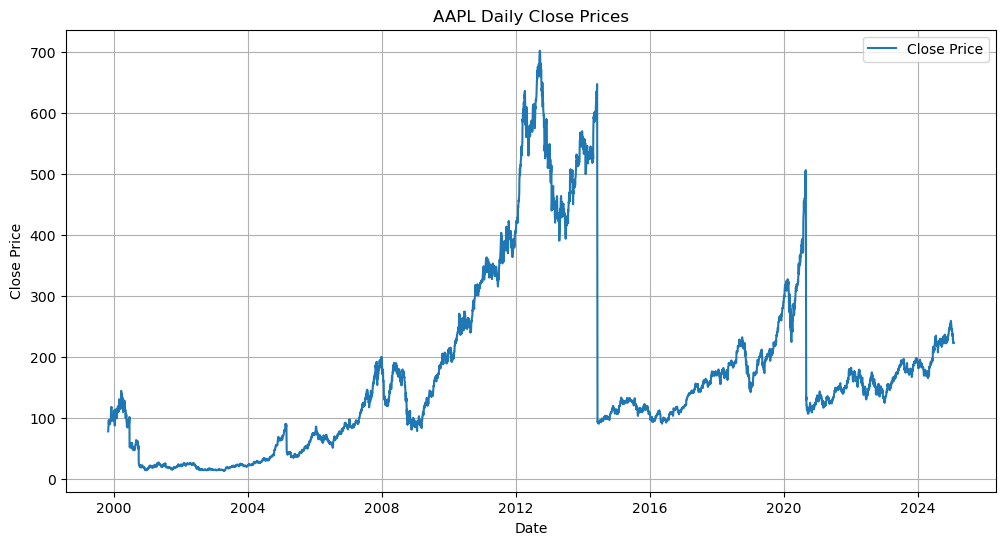

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [17]:
!pip install requests alpha_vantage
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import requests


### 2 data sources (1st Alpha Vantage API /  yfinance)


# Define API key and parameters
api_key = 'DJQ5NJKTBGZAJLBJ'
techassets = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'ORCL', 'META', 'TSLA', 'NVDA']
bankingassets = ['BRK-B', 'JPM', 'V', 'BAC', 'AXP', 'GS', 'BLK', 'STT']
healthcareassets = ['LLY', 'JNJ', 'ABT', 'MDT', 'UNH', 'PFE', 'CVS', 'MRK']
all_assets = techassets + bankingassets + healthcareassets

# Function to fetch data from Alpha Vantage
def fetch_data(symbol, api_key):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={api_key}&outputsize=full'
    r = requests.get(url)
    data = r.json()
    if 'Time Series (Daily)' in data:
        return data['Time Series (Daily)']
    else:
        print(f"Error fetching data for {symbol}: {data.get('Note', data)}")
        return None

# Initialize an empty DataFrame to store the data
combined_data = pd.DataFrame()

# Fetch data for each stock and store it in the DataFrame
for ticker in all_assets:
    print(f"Fetching data for {ticker}...")
    time_series = fetch_data(ticker, api_key)
    if time_series is not None:
        df = pd.DataFrame.from_dict(time_series, orient='index')
        df = df.rename(columns={
            '1. open': 'Open',
            '2. high': 'High',
            '3. low': 'Low',
            '4. close': 'Close',
            '5. volume': 'Volume'  # This is the correct key for volume in TIME_SERIES_DAILY
        })
        df = df.astype(float, errors='ignore')  # Convert to float for numerical operations, ignoring errors
        df.index = pd.to_datetime(df.index)  # Convert index to datetime
        # Check if all required columns are present, if not fill with NaN
        required_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        for col in required_columns:
            if col not in df.columns:
                df[col] = float('nan')
        df = df[required_columns]  # Ensure the DataFrame has all required columns
        df['Ticker'] = ticker  # Add a column for the ticker symbol
        combined_data = pd.concat([combined_data, df])

# Print the head of the combined DataFrame
print(combined_data.head())

# Function to plot closing prices for a specific asset
def plot_closing_price(ticker, combined_data):
    if 'Ticker' not in combined_data.columns:
        print(f"No data found for {ticker}")
        return
    df = combined_data[combined_data['Ticker'] == ticker]
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Close'], label='Close Price')
    plt.title(f'{ticker} Daily Close Prices')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot closing prices for a sample stock (e.g., AAPL)
plot_closing_price('AAPL', combined_data)







# yfinance data below(Alpha_Vantage_api data above)
# Define stock tickers
techassets = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'ORCL', 'META', 'TSLA', 'NVDA']
bankingassets = ['BRK-B', 'JPM', 'V', 'BAC', 'AXP', 'GS', 'BLK', 'STT']
healthcareassets = ['LLY', 'JNJ', 'ABT', 'MDT', 'UNH', 'PFE', 'CVS', 'MRK']
all_assets = techassets + bankingassets + healthcareassets

# Define date range
start_date = '2014-01-01'
end_date = '2025-01-01'

# Fetch stock data using yfinance
stock_data = {}
for ticker in all_assets:
    stock_data[ticker] = yf.download(ticker, start=start_date, end=end_date)

# Fetch S&P 500 data
sp500_data = yf.download('^GSPC', start=start_date, end=end_date)

# Combine data into a single DataFrame
combined_data = pd.concat([stock_data[ticker][['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']] for ticker in all_assets], axis=1)
combined_data.columns = pd.MultiIndex.from_product([all_assets, ['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']])

# Add S&P 500 data to the combined data
combined_data[('SP500', 'Close')] = sp500_data['Close']

# Normalize data
scalers = {}
scaled_data = combined_data.copy()
for asset in all_assets:
    for col in combined_data.columns.levels[1]:
        scalers[(asset, col)] = MinMaxScaler(feature_range=(0, 1))
        scaled_data[(asset, col)] = scalers[(asset, col)].fit_transform(combined_data[(asset, col)].values.reshape(-1, 1))

# Normalize S&P 500 data separately
scalers[('SP500', 'Close')] = MinMaxScaler(feature_range=(0, 1))
scaled_data[('SP500', 'Close')] = scalers[('SP500', 'Close')].fit_transform(combined_data[('SP500', 'Close')].values.reshape(-1, 1))